In [223]:
import cv2

original_img = cv2.imread('./images/flappy_bird.png')

In [224]:
original_img

array([[[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       ...,

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [164, 212, 163],
        [164, 213, 163],
        [164, 213, 163]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [149, 206, 149],
        [148, 207, 149],
        [148, 207, 149]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [138, 204, 139],
        [137, 204, 139],
        [136, 204, 139]]

In [225]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def preprocess(prev_frame: Path | str, current_frame: Path | str) -> Path | str:
    # Read the input frames to get a 3D array: (rows x cols x channels)
    prev_img = cv2.imread(str(prev_frame))
    current_img = cv2.imread(str(current_frame))
    new_frame = np.maximum(prev_img, current_img)
    gray_img = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    rescaled_img = cv2.resize(gray_img, (84, 84), interpolation=cv2.INTER_AREA)
    plt.imshow(rescaled_img, cmap="gray", interpolation="nearest")
    plt.show()
    return rescaled_img

def preprocess_frame(frame: np.ndarray) -> np.ndarray:
    """
    Preprocess a single frame for DQN input.
    
    Args:
        frame: RGB frame from env.render() with shape (H, W, 3) or (H, W)
        
    Returns:
        Preprocessed grayscale frame of shape (84, 84) with values normalized to [0, 1]
    """
    # Convert RGB to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray = frame
    
    # Resize to 84x84
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1] range
    normalized = resized.astype(np.float32) / 255.0
    
    return normalized

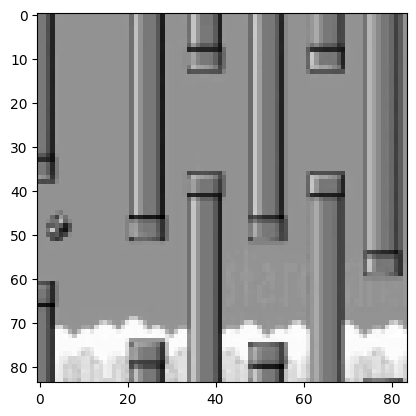

array([[160, 160, 134, ..., 125, 141, 176],
       [160, 160, 135, ..., 125, 142, 178],
       [160, 160, 135, ..., 125, 143, 177],
       ...,
       [160, 160, 134, ..., 236, 230, 219],
       [160, 160, 134, ..., 232, 229, 219],
       [160, 160, 134, ..., 139, 133, 206]], shape=(84, 84), dtype=uint8)

In [226]:
prev_frame = "./images/flappy_bird.png"
current_frame = "./images/flappy_bird.png"

preprocess(prev_frame, current_frame)

In [227]:
def conv2d_output_size(input_size, kernel_size, stride, padding=0):
    """
    Calculate the output size of a 2D convolutional layer.
    
    Formula: output_size = (input_size - kernel_size + 2*padding) / stride + 1
    
    Args:
        input_size: Input height/width (int or tuple)
        kernel_size: Kernel size (int or tuple)
        stride: Stride (int or tuple)
        padding: Padding (int or tuple, default=0)
    
    Returns:
        Output size (int or tuple)
    """
    if isinstance(input_size, tuple):
        # Handle tuple input (height, width)
        h, w = input_size
        
        # Handle kernel_size - convert int to tuple if needed
        if isinstance(kernel_size, tuple):
            k_h, k_w = kernel_size
        else:
            k_h = k_w = kernel_size
        
        # Handle stride - convert int to tuple if needed
        if isinstance(stride, tuple):
            s_h, s_w = stride
        else:
            s_h = s_w = stride
        
        # Handle padding - convert int to tuple if needed
        if isinstance(padding, tuple):
            p_h, p_w = padding
        else:
            p_h = p_w = padding
        
        o_h = (h - k_h + 2 * p_h) // s_h + 1
        o_w = (w - k_w + 2 * p_w) // s_w + 1
        return (int(o_h), int(o_w))
    else:
        # Handle single dimension
        k = kernel_size if isinstance(kernel_size, int) else kernel_size[0]
        s = stride if isinstance(stride, int) else stride[0]
        p = padding if isinstance(padding, int) else padding[0]
        return int((input_size - k + 2 * p) // s + 1)

In [228]:
class FrameBuffer:
    """
    Maintains a buffer of the last 4 preprocessed frames.
    Handles initial steps by repeating the first frame.
    """
    
    def __init__(self, frame_shape=(84, 84)):
        self.frame_shape = frame_shape
        self.buffer = np.zeros((4, *frame_shape), dtype=np.float32)
        self.count = 0
    
    def add_frame(self, frame: np.ndarray) -> np.ndarray:
        """
        Add a new frame to the buffer and return stacked frames.
        
        Args:
            frame: Preprocessed frame of shape (84, 84)
            
        Returns:
            Stacked frames of shape (4, 84, 84) ready for DQN input
        """
        # For the first frame, fill the buffer with the same frame
        if self.count == 0:
            self.buffer[:] = frame
        else:
            # Shift frames: remove oldest, add newest
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = frame
        
        self.count += 1
        return self.buffer.copy()
    
    def reset(self):
        """Reset the buffer (call when environment resets)."""
        self.buffer.fill(0)
        self.count = 0
    
    def get_stacked_frames(self) -> np.ndarray:
        """Get current stacked frames without adding a new frame."""
        return self.buffer.copy()


In [229]:
def process_observation(observation, frame_buffer: FrameBuffer, env) -> np.ndarray:
    """
    Process a raw observation into DQN-ready input.
    
    Args:
        observation: Raw observation from env (may be vector or None)
        frame_buffer: FrameBuffer instance
        env: Environment instance (for rendering)
        
    Returns:
        Stacked frames of shape (4, 84, 84) ready for DQN
    """
    # Render to get RGB frame
    rgb_frame = env.render()
    
    # Preprocess the frame
    processed_frame = preprocess_frame(rgb_frame)
    
    # Add to buffer and get stacked frames
    stacked = frame_buffer.add_frame(processed_frame)
    
    return stacked


In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [231]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    """
    Deep Q-Network as in Mnih et al. (2015)
    Input: (B, 4, 84, 84)
    Output: Q-values for each action
    """

    def __init__(self, num_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # compute conv output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.conv(dummy).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [232]:
# Test the DQN model architecture
# Create a model instance
model = DQN(num_actions=2)

# Create a dummy input: batch_size=1, 4 stacked frames, 84x84 grayscale
dummy_input = torch.randn(1, 4, 84, 84)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print(f"Model architecture:")
print(model)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: (1, 2) - one Q-value per action")
print(f"\nQ-values: {output}")


Model architecture:
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

Input shape: torch.Size([1, 4, 84, 84])
Output shape: torch.Size([1, 2])
Expected output shape: (1, 2) - one Q-value per action

Q-values: tensor([[ 0.0010, -0.0216]])


In [233]:
import random
from collections import deque


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


In [234]:
import numpy as np


class DQNAgent:
    def __init__(
        self,
        q_net,
        num_actions,
        eps_start=1.0,
        eps_end=0.1,
        eps_decay_steps=1_000_000,
    ):
        self.q_net = q_net
        self.num_actions = num_actions

        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps
        self.steps_done = 0

    def epsilon(self):
        frac = min(self.steps_done / self.eps_decay_steps, 1.0)
        return self.eps_start + frac * (self.eps_end - self.eps_start)

    def act(self, state):
        self.steps_done += 1

        if np.random.rand() < self.epsilon():
            return np.random.randint(self.num_actions)

        with torch.no_grad():
            q_values = self.q_net(state.unsqueeze(0))
            return q_values.argmax(dim=1).item()


In [235]:
import torch.optim as optim


class DQNTrainer:
    def __init__(
        self,
        q_net,
        target_net,
        replay_buffer,
        gamma=0.99,
        lr=2.5e-4,
        batch_size=32,
        target_update_freq=10_000,
        device="cpu",
    ):
        self.q_net = q_net.to(device)
        self.target_net = target_net.to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.device = device

        self.optimizer = optim.RMSprop(
            self.q_net.parameters(),
            lr=lr,
            alpha=0.95,
            eps=0.01,
        )

        # Huber loss = clipped TD error (paper)
        self.loss_fn = nn.SmoothL1Loss()

        self.train_steps = 0

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(
            self.batch_size
        )

        # Convert numpy arrays to tensors before stacking
        # States are numpy arrays of shape (4, 84, 84), need to convert to tensors first
        state = torch.stack([torch.FloatTensor(s) for s in state]).to(self.device)
        next_state = torch.stack([torch.FloatTensor(s) for s in next_state]).to(self.device)
        action = torch.tensor(action).to(self.device)
        reward = torch.tensor(reward).to(self.device)
        done = torch.tensor(done).to(self.device)

        # Q(s, a)
        q_values = self.q_net(state)
        q_sa = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

        # target: r + γ max_a' Q̂(s', a')
        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            # Convert done to float tensor for arithmetic operations
            target = reward + self.gamma * next_q * (1 - done.float())

        loss = self.loss_fn(q_sa, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # periodic target update
        if self.train_steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.train_steps += 1


In [236]:
!pip install flappy-bird-gymnasium

In [237]:
import gymnasium as gym

env = gym.make("FlappyBird-v0")

In [238]:
# Check the environment properties
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Reset the environment to get initial state
observation, info = env.reset()
print(f"Initial observation shape: {observation.shape}")

# Take a random action
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
print(f"Reward: {reward}, Terminated: {terminated}")

# Close the environment when done
env.close()

Action space: Discrete(2)
Observation space: Box(0.0, 1.0, (180,), float64)
Initial observation shape: (180,)
Reward: 0.1, Terminated: False


In [239]:
# Test the preprocessing pipeline
import gymnasium as gym

# Create environment with rgb_array render mode to get pixel observations
env = gym.make("FlappyBird-v0", render_mode='rgb_array')
frame_buffer = FrameBuffer()

# Reset environment
observation, info = env.reset()

# Process first observation
stacked_frames = process_observation(observation, frame_buffer, env)
print(f"Stacked frames shape: {stacked_frames.shape}")
print(f"Expected: (4, 84, 84)")
print(f"Frame buffer count: {frame_buffer.count}")
print(f"Frame value range: [{stacked_frames.min():.3f}, {stacked_frames.max():.3f}]")

# Take a few steps to test frame stacking
for i in range(3):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    stacked_frames = process_observation(observation, frame_buffer, env)
    print(f"Step {i+1}: Stacked frames shape: {stacked_frames.shape}, count: {frame_buffer.count}")

# Test reset
frame_buffer.reset()
print(f"\nAfter reset - buffer count: {frame_buffer.count}")
print(f"Buffer after reset (should be all zeros): {np.allclose(frame_buffer.buffer, 0)}")

env.close()
print("\n✓ Preprocessing pipeline test completed successfully!")


Stacked frames shape: (4, 84, 84)
Expected: (4, 84, 84)
Frame buffer count: 1
Frame value range: [0.329, 0.957]
Step 1: Stacked frames shape: (4, 84, 84), count: 2
Step 2: Stacked frames shape: (4, 84, 84), count: 3
Step 3: Stacked frames shape: (4, 84, 84), count: 4

After reset - buffer count: 0
Buffer after reset (should be all zeros): True

✓ Preprocessing pipeline test completed successfully!


In [ ]:
# Training loop with visualization
import gymnasium as gym
import torch
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Install tqdm if not available: !pip install tqdm
try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found. Install with: !pip install tqdm")
    # Fallback: use range instead of tqdm
    def tqdm(iterable, desc=""):
        return iterable

# Hyperparameters
NUM_EPISODES = 4000
MAX_STEPS_PER_EPISODE = 1000
REPLAY_BUFFER_SIZE = 10000
BATCH_SIZE = 32
LEARNING_RATE = 2.5e-4
GAMMA = 0.99
TARGET_UPDATE_FREQ = 100
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY_STEPS = 10000
MIN_REPLAY_SIZE = 1000

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create environment
env = gym.make("FlappyBird-v0", render_mode='rgb_array')
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

# Initialize networks
q_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

# Initialize components
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
frame_buffer = FrameBuffer()
trainer = DQNTrainer(
    q_net=q_net,
    target_net=target_net,
    replay_buffer=replay_buffer,
    gamma=GAMMA,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    target_update_freq=TARGET_UPDATE_FREQ,
    device=device
)
agent = DQNAgent(
    q_net=q_net,
    num_actions=num_actions,
    eps_start=EPS_START,
    eps_end=EPS_END,
    eps_decay_steps=EPS_DECAY_STEPS
)

# Tracking metrics
episode_rewards = []
episode_lengths = []
losses = []
epsilon_values = []

print("\nStarting training...")
print(f"Will train for {NUM_EPISODES} episodes")
print(f"Training will start after {MIN_REPLAY_SIZE} experiences are collected\n")


Using device: cpu
Number of actions: 2

Starting training...
Will train for 2000 episodes
Training will start after 1000 experiences are collected



In [241]:
# Training loop
for episode in tqdm(range(NUM_EPISODES), desc="Training"):
    # Reset environment and frame buffer
    observation, info = env.reset()
    frame_buffer.reset()
    
    # Get initial state
    state = process_observation(observation, frame_buffer, env)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add batch dimension
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(MAX_STEPS_PER_EPISODE):
        # Select action
        epsilon = agent.epsilon()
        epsilon_values.append(epsilon)
        
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = agent.q_net(state_tensor)
                action = q_values.argmax(1).item()
        
        agent.steps_done += 1
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Process next observation
        next_state = process_observation(next_observation, frame_buffer, env)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        
        # Store experience in replay buffer (state is already numpy array from process_observation)
        replay_buffer.push(
            state=state,  # Already numpy array
            action=action,
            reward=reward,
            next_state=next_state,  # Already numpy array
            done=done
        )
        
        episode_reward += reward
        episode_length += 1
        
        # Train if we have enough experiences
        if len(replay_buffer) >= MIN_REPLAY_SIZE:
            trainer.train_step()
        
        # Update state
        state = next_state
        state_tensor = next_state_tensor
        
        if done:
            break
    
    # Record episode metrics
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_length = np.mean(episode_lengths[-10:])
        current_eps = agent.epsilon()
        print(f"\nEpisode {episode + 1}/{NUM_EPISODES}")
        print(f"  Average reward (last 10): {avg_reward:.2f}")
        print(f"  Average length (last 10): {avg_length:.1f}")
        print(f"  Current epsilon: {current_eps:.3f}")
        print(f"  Replay buffer size: {len(replay_buffer)}")

env.close()
print("\n✓ Training completed!")


Training:   0%|          | 10/2000 [00:03<09:45,  3.40it/s]


Episode 10/2000
  Average reward (last 10): -7.86
  Average length (last 10): 50.0
  Current epsilon: 0.955
  Replay buffer size: 500


Training:   1%|          | 20/2000 [00:06<10:35,  3.12it/s]


Episode 20/2000
  Average reward (last 10): -8.22
  Average length (last 10): 50.0
  Current epsilon: 0.910
  Replay buffer size: 1000


Training:   2%|▏         | 30/2000 [00:41<1:53:07,  3.45s/it]


Episode 30/2000
  Average reward (last 10): -7.68
  Average length (last 10): 50.0
  Current epsilon: 0.865
  Replay buffer size: 1500


Training:   2%|▏         | 40/2000 [01:11<1:32:21,  2.83s/it]


Episode 40/2000
  Average reward (last 10): -7.86
  Average length (last 10): 50.0
  Current epsilon: 0.820
  Replay buffer size: 2000


Training:   2%|▎         | 50/2000 [01:39<1:32:28,  2.85s/it]


Episode 50/2000
  Average reward (last 10): -7.26
  Average length (last 10): 50.0
  Current epsilon: 0.775
  Replay buffer size: 2500


Training:   3%|▎         | 60/2000 [02:07<1:29:48,  2.78s/it]


Episode 60/2000
  Average reward (last 10): -7.80
  Average length (last 10): 50.0
  Current epsilon: 0.730
  Replay buffer size: 3000


Training:   4%|▎         | 70/2000 [02:37<1:37:20,  3.03s/it]


Episode 70/2000
  Average reward (last 10): -7.32
  Average length (last 10): 50.0
  Current epsilon: 0.685
  Replay buffer size: 3500


Training:   4%|▍         | 80/2000 [03:05<1:28:18,  2.76s/it]


Episode 80/2000
  Average reward (last 10): -7.80
  Average length (last 10): 50.0
  Current epsilon: 0.640
  Replay buffer size: 4000


Training:   4%|▍         | 90/2000 [03:33<1:26:46,  2.73s/it]


Episode 90/2000
  Average reward (last 10): -7.56
  Average length (last 10): 50.0
  Current epsilon: 0.595
  Replay buffer size: 4500


Training:   5%|▌         | 100/2000 [04:01<1:29:09,  2.82s/it]


Episode 100/2000
  Average reward (last 10): -6.78
  Average length (last 10): 50.0
  Current epsilon: 0.550
  Replay buffer size: 5000


Training:   6%|▌         | 110/2000 [04:30<1:32:46,  2.95s/it]


Episode 110/2000
  Average reward (last 10): -7.38
  Average length (last 10): 50.0
  Current epsilon: 0.505
  Replay buffer size: 5500


Training:   6%|▌         | 120/2000 [04:58<1:26:59,  2.78s/it]


Episode 120/2000
  Average reward (last 10): -6.54
  Average length (last 10): 50.0
  Current epsilon: 0.460
  Replay buffer size: 6000


Training:   6%|▋         | 130/2000 [05:26<1:29:42,  2.88s/it]


Episode 130/2000
  Average reward (last 10): -6.96
  Average length (last 10): 50.0
  Current epsilon: 0.415
  Replay buffer size: 6500


Training:   7%|▋         | 140/2000 [05:55<1:26:51,  2.80s/it]


Episode 140/2000
  Average reward (last 10): -6.12
  Average length (last 10): 50.0
  Current epsilon: 0.370
  Replay buffer size: 7000


Training:   8%|▊         | 150/2000 [06:23<1:25:40,  2.78s/it]


Episode 150/2000
  Average reward (last 10): -6.90
  Average length (last 10): 50.0
  Current epsilon: 0.325
  Replay buffer size: 7500


Training:   8%|▊         | 160/2000 [06:53<1:44:26,  3.41s/it]


Episode 160/2000
  Average reward (last 10): -5.64
  Average length (last 10): 50.0
  Current epsilon: 0.280
  Replay buffer size: 8000


Training:   8%|▊         | 170/2000 [07:23<1:29:00,  2.92s/it]


Episode 170/2000
  Average reward (last 10): -5.94
  Average length (last 10): 50.0
  Current epsilon: 0.235
  Replay buffer size: 8500


Training:   9%|▉         | 180/2000 [07:51<1:24:33,  2.79s/it]


Episode 180/2000
  Average reward (last 10): -5.82
  Average length (last 10): 50.0
  Current epsilon: 0.190
  Replay buffer size: 9000


Training:  10%|▉         | 190/2000 [08:21<1:36:29,  3.20s/it]


Episode 190/2000
  Average reward (last 10): -4.08
  Average length (last 10): 50.0
  Current epsilon: 0.145
  Replay buffer size: 9500


Training:  10%|█         | 200/2000 [08:52<1:35:02,  3.17s/it]


Episode 200/2000
  Average reward (last 10): -4.14
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|█         | 210/2000 [09:23<1:33:34,  3.14s/it]


Episode 210/2000
  Average reward (last 10): -4.44
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  11%|█         | 220/2000 [09:53<1:25:28,  2.88s/it]


Episode 220/2000
  Average reward (last 10): -3.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 230/2000 [10:23<1:24:47,  2.87s/it]


Episode 230/2000
  Average reward (last 10): -3.12
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 240/2000 [10:51<1:24:02,  2.86s/it]


Episode 240/2000
  Average reward (last 10): -3.18
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▎        | 250/2000 [11:19<1:24:35,  2.90s/it]


Episode 250/2000
  Average reward (last 10): -4.56
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  13%|█▎        | 260/2000 [11:49<1:23:27,  2.88s/it]


Episode 260/2000
  Average reward (last 10): -3.84
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▎        | 270/2000 [12:17<1:21:32,  2.83s/it]


Episode 270/2000
  Average reward (last 10): -4.74
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 280/2000 [12:49<1:26:41,  3.02s/it]


Episode 280/2000
  Average reward (last 10): -3.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 290/2000 [13:19<1:25:31,  3.00s/it]


Episode 290/2000
  Average reward (last 10): -3.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  15%|█▌        | 300/2000 [13:48<1:20:13,  2.83s/it]


Episode 300/2000
  Average reward (last 10): -5.46
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▌        | 310/2000 [14:25<1:45:24,  3.74s/it]


Episode 310/2000
  Average reward (last 10): -2.58
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▌        | 320/2000 [15:02<1:45:47,  3.78s/it]


Episode 320/2000
  Average reward (last 10): -2.22
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▋        | 330/2000 [15:39<1:41:48,  3.66s/it]


Episode 330/2000
  Average reward (last 10): -2.88
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  17%|█▋        | 340/2000 [16:15<1:31:26,  3.31s/it]


Episode 340/2000
  Average reward (last 10): -3.90
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 350/2000 [16:45<1:21:51,  2.98s/it]


Episode 350/2000
  Average reward (last 10): -4.46
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 360/2000 [17:13<1:15:28,  2.76s/it]


Episode 360/2000
  Average reward (last 10): -3.97
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 370/2000 [17:40<1:14:12,  2.73s/it]


Episode 370/2000
  Average reward (last 10): -3.64
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  19%|█▉        | 380/2000 [18:08<1:15:15,  2.79s/it]


Episode 380/2000
  Average reward (last 10): -2.96
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|█▉        | 390/2000 [18:35<1:13:12,  2.73s/it]


Episode 390/2000
  Average reward (last 10): -3.07
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|██        | 400/2000 [19:02<1:11:51,  2.69s/it]


Episode 400/2000
  Average reward (last 10): -4.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|██        | 410/2000 [19:29<1:11:59,  2.72s/it]


Episode 410/2000
  Average reward (last 10): -4.93
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  21%|██        | 420/2000 [19:57<1:11:21,  2.71s/it]


Episode 420/2000
  Average reward (last 10): -2.14
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 430/2000 [20:24<1:10:54,  2.71s/it]


Episode 430/2000
  Average reward (last 10): -4.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 440/2000 [20:52<1:10:54,  2.73s/it]


Episode 440/2000
  Average reward (last 10): -3.18
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▎       | 450/2000 [21:19<1:11:39,  2.77s/it]


Episode 450/2000
  Average reward (last 10): -1.91
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  23%|██▎       | 460/2000 [21:46<1:09:23,  2.70s/it]


Episode 460/2000
  Average reward (last 10): -2.28
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▎       | 470/2000 [22:14<1:12:55,  2.86s/it]


Episode 470/2000
  Average reward (last 10): -2.15
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 480/2000 [22:43<1:10:50,  2.80s/it]


Episode 480/2000
  Average reward (last 10): -1.98
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 490/2000 [23:11<1:13:13,  2.91s/it]


Episode 490/2000
  Average reward (last 10): -3.96
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  25%|██▌       | 500/2000 [23:39<1:10:31,  2.82s/it]


Episode 500/2000
  Average reward (last 10): -2.04
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▌       | 510/2000 [24:08<1:11:01,  2.86s/it]


Episode 510/2000
  Average reward (last 10): -1.25
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▌       | 520/2000 [24:36<1:09:46,  2.83s/it]


Episode 520/2000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▋       | 530/2000 [25:05<1:11:44,  2.93s/it]


Episode 530/2000
  Average reward (last 10): -3.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  27%|██▋       | 540/2000 [25:34<1:10:08,  2.88s/it]


Episode 540/2000
  Average reward (last 10): -1.07
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 550/2000 [26:03<1:09:49,  2.89s/it]


Episode 550/2000
  Average reward (last 10): -1.26
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 560/2000 [26:32<1:09:50,  2.91s/it]


Episode 560/2000
  Average reward (last 10): -1.62
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 570/2000 [27:02<1:09:39,  2.92s/it]


Episode 570/2000
  Average reward (last 10): -1.86
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  29%|██▉       | 580/2000 [27:31<1:09:16,  2.93s/it]


Episode 580/2000
  Average reward (last 10): -2.28
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|██▉       | 590/2000 [28:01<1:10:30,  3.00s/it]


Episode 590/2000
  Average reward (last 10): -0.91
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|███       | 600/2000 [28:31<1:08:45,  2.95s/it]


Episode 600/2000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|███       | 610/2000 [29:00<1:08:21,  2.95s/it]


Episode 610/2000
  Average reward (last 10): -1.20
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  31%|███       | 620/2000 [29:30<1:07:45,  2.95s/it]


Episode 620/2000
  Average reward (last 10): -1.32
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 630/2000 [30:00<1:07:05,  2.94s/it]


Episode 630/2000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 640/2000 [30:30<1:06:39,  2.94s/it]


Episode 640/2000
  Average reward (last 10): -0.90
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▎      | 650/2000 [30:59<1:05:57,  2.93s/it]


Episode 650/2000
  Average reward (last 10): -2.22
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  33%|███▎      | 660/2000 [31:28<1:05:25,  2.93s/it]


Episode 660/2000
  Average reward (last 10): -1.32
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▎      | 670/2000 [31:58<1:05:05,  2.94s/it]


Episode 670/2000
  Average reward (last 10): -1.10
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 680/2000 [32:28<1:06:52,  3.04s/it]


Episode 680/2000
  Average reward (last 10): -0.90
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 690/2000 [32:57<1:05:03,  2.98s/it]


Episode 690/2000
  Average reward (last 10): -1.28
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  35%|███▌      | 700/2000 [33:27<1:02:59,  2.91s/it]


Episode 700/2000
  Average reward (last 10): -1.43
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▌      | 710/2000 [33:56<1:02:00,  2.88s/it]


Episode 710/2000
  Average reward (last 10): -1.56
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▌      | 720/2000 [34:25<1:02:33,  2.93s/it]


Episode 720/2000
  Average reward (last 10): -0.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▋      | 730/2000 [34:55<1:01:50,  2.92s/it]


Episode 730/2000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  37%|███▋      | 740/2000 [35:25<1:01:24,  2.92s/it]


Episode 740/2000
  Average reward (last 10): -0.60
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 750/2000 [35:54<1:00:24,  2.90s/it]


Episode 750/2000
  Average reward (last 10): -0.65
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 760/2000 [36:23<1:00:57,  2.95s/it]


Episode 760/2000
  Average reward (last 10): -0.53
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 770/2000 [36:52<59:58,  2.93s/it]  


Episode 770/2000
  Average reward (last 10): -1.14
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  39%|███▉      | 780/2000 [37:22<59:51,  2.94s/it]  


Episode 780/2000
  Average reward (last 10): -0.30
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|███▉      | 790/2000 [37:51<59:03,  2.93s/it]


Episode 790/2000
  Average reward (last 10): -0.52
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|████      | 800/2000 [38:21<59:34,  2.98s/it]  


Episode 800/2000
  Average reward (last 10): -0.07
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|████      | 810/2000 [38:50<57:39,  2.91s/it]


Episode 810/2000
  Average reward (last 10): -0.29
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  41%|████      | 820/2000 [39:21<58:37,  2.98s/it]  


Episode 820/2000
  Average reward (last 10): -0.39
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 830/2000 [39:52<59:04,  3.03s/it]  


Episode 830/2000
  Average reward (last 10): 0.42
  Average length (last 10): 52.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 840/2000 [40:22<58:17,  3.01s/it]


Episode 840/2000
  Average reward (last 10): -0.33
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▎     | 850/2000 [40:51<55:39,  2.90s/it]


Episode 850/2000
  Average reward (last 10): -0.40
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  43%|████▎     | 860/2000 [41:21<57:22,  3.02s/it]  


Episode 860/2000
  Average reward (last 10): -0.38
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▎     | 870/2000 [41:51<55:38,  2.95s/it]


Episode 870/2000
  Average reward (last 10): -0.92
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 880/2000 [42:21<56:19,  3.02s/it]


Episode 880/2000
  Average reward (last 10): -0.40
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 890/2000 [42:51<54:44,  2.96s/it]


Episode 890/2000
  Average reward (last 10): -0.31
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  45%|████▌     | 900/2000 [43:22<54:54,  2.99s/it]


Episode 900/2000
  Average reward (last 10): -0.74
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▌     | 910/2000 [43:51<52:37,  2.90s/it]


Episode 910/2000
  Average reward (last 10): -0.64
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▌     | 920/2000 [44:21<53:35,  2.98s/it]


Episode 920/2000
  Average reward (last 10): -0.30
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▋     | 930/2000 [44:50<51:52,  2.91s/it]


Episode 930/2000
  Average reward (last 10): -0.56
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  47%|████▋     | 940/2000 [45:19<52:42,  2.98s/it]


Episode 940/2000
  Average reward (last 10): -0.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 950/2000 [45:50<51:57,  2.97s/it]


Episode 950/2000
  Average reward (last 10): -0.39
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 960/2000 [46:19<51:45,  2.99s/it]


Episode 960/2000
  Average reward (last 10): -0.26
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 970/2000 [46:48<48:59,  2.85s/it]


Episode 970/2000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  49%|████▉     | 980/2000 [47:17<48:52,  2.88s/it]


Episode 980/2000
  Average reward (last 10): -0.16
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|████▉     | 990/2000 [47:46<47:33,  2.82s/it]


Episode 990/2000
  Average reward (last 10): -1.12
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|█████     | 1000/2000 [48:14<47:21,  2.84s/it]


Episode 1000/2000
  Average reward (last 10): 0.96
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|█████     | 1010/2000 [48:43<49:16,  2.99s/it]


Episode 1010/2000
  Average reward (last 10): 0.58
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  51%|█████     | 1020/2000 [49:12<48:07,  2.95s/it]


Episode 1020/2000
  Average reward (last 10): -0.21
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 1030/2000 [49:41<47:05,  2.91s/it]


Episode 1030/2000
  Average reward (last 10): -0.40
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 1040/2000 [50:09<45:54,  2.87s/it]


Episode 1040/2000
  Average reward (last 10): -0.44
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▎    | 1050/2000 [50:38<45:02,  2.85s/it]


Episode 1050/2000
  Average reward (last 10): -0.28
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  53%|█████▎    | 1060/2000 [51:06<43:08,  2.75s/it]


Episode 1060/2000
  Average reward (last 10): -0.32
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▎    | 1070/2000 [51:34<42:33,  2.75s/it]


Episode 1070/2000
  Average reward (last 10): -0.06
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▍    | 1080/2000 [52:02<43:31,  2.84s/it]


Episode 1080/2000
  Average reward (last 10): -0.38
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▍    | 1090/2000 [52:30<42:55,  2.83s/it]


Episode 1090/2000
  Average reward (last 10): 0.11
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▌    | 1100/2000 [52:58<41:28,  2.77s/it]


Episode 1100/2000
  Average reward (last 10): -1.00
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▌    | 1110/2000 [53:27<42:03,  2.84s/it]


Episode 1110/2000
  Average reward (last 10): 1.00
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▌    | 1120/2000 [53:54<39:43,  2.71s/it]


Episode 1120/2000
  Average reward (last 10): -0.77
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▋    | 1130/2000 [54:22<39:31,  2.73s/it]


Episode 1130/2000
  Average reward (last 10): -0.24
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▋    | 1140/2000 [54:50<41:28,  2.89s/it]


Episode 1140/2000
  Average reward (last 10): 0.40
  Average length (last 10): 53.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▊    | 1150/2000 [55:18<38:54,  2.75s/it]


Episode 1150/2000
  Average reward (last 10): -0.48
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 1160/2000 [55:45<38:36,  2.76s/it]


Episode 1160/2000
  Average reward (last 10): 0.35
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 1170/2000 [56:13<38:18,  2.77s/it]


Episode 1170/2000
  Average reward (last 10): -0.94
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  59%|█████▉    | 1180/2000 [56:40<38:06,  2.79s/it]


Episode 1180/2000
  Average reward (last 10): 0.05
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|█████▉    | 1190/2000 [57:08<37:08,  2.75s/it]


Episode 1190/2000
  Average reward (last 10): -0.42
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|██████    | 1200/2000 [57:35<36:04,  2.71s/it]


Episode 1200/2000
  Average reward (last 10): -0.38
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|██████    | 1210/2000 [58:03<36:10,  2.75s/it]


Episode 1210/2000
  Average reward (last 10): -0.23
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  61%|██████    | 1220/2000 [58:31<36:53,  2.84s/it]


Episode 1220/2000
  Average reward (last 10): -0.24
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 1230/2000 [58:59<35:34,  2.77s/it]


Episode 1230/2000
  Average reward (last 10): -0.10
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 1240/2000 [59:26<35:02,  2.77s/it]


Episode 1240/2000
  Average reward (last 10): 0.00
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▎   | 1250/2000 [59:55<34:21,  2.75s/it]


Episode 1250/2000
  Average reward (last 10): -0.18
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  63%|██████▎   | 1260/2000 [1:00:23<33:56,  2.75s/it]


Episode 1260/2000
  Average reward (last 10): -0.24
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▎   | 1270/2000 [1:00:50<33:16,  2.74s/it]


Episode 1270/2000
  Average reward (last 10): -0.80
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 1280/2000 [1:01:18<33:53,  2.82s/it]


Episode 1280/2000
  Average reward (last 10): 0.71
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 1290/2000 [1:01:46<32:21,  2.74s/it]


Episode 1290/2000
  Average reward (last 10): 0.68
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  65%|██████▌   | 1300/2000 [1:02:14<32:10,  2.76s/it]


Episode 1300/2000
  Average reward (last 10): -0.63
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▌   | 1310/2000 [1:02:41<31:11,  2.71s/it]


Episode 1310/2000
  Average reward (last 10): -0.10
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▌   | 1320/2000 [1:03:08<31:25,  2.77s/it]


Episode 1320/2000
  Average reward (last 10): -0.96
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▋   | 1330/2000 [1:03:36<30:18,  2.71s/it]


Episode 1330/2000
  Average reward (last 10): 0.10
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  67%|██████▋   | 1340/2000 [1:04:04<30:32,  2.78s/it]


Episode 1340/2000
  Average reward (last 10): -0.02
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 1350/2000 [1:04:31<29:25,  2.72s/it]


Episode 1350/2000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 1360/2000 [1:04:59<29:02,  2.72s/it]


Episode 1360/2000
  Average reward (last 10): 0.09
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 1370/2000 [1:05:27<28:51,  2.75s/it]


Episode 1370/2000
  Average reward (last 10): 0.04
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  69%|██████▉   | 1380/2000 [1:05:54<28:44,  2.78s/it]


Episode 1380/2000
  Average reward (last 10): 0.01
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|██████▉   | 1390/2000 [1:06:22<28:10,  2.77s/it]


Episode 1390/2000
  Average reward (last 10): -0.98
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|███████   | 1400/2000 [1:06:50<27:27,  2.75s/it]


Episode 1400/2000
  Average reward (last 10): -0.36
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|███████   | 1410/2000 [1:07:17<27:23,  2.79s/it]


Episode 1410/2000
  Average reward (last 10): -0.13
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  71%|███████   | 1420/2000 [1:07:44<26:15,  2.72s/it]


Episode 1420/2000
  Average reward (last 10): -0.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 1430/2000 [1:08:12<26:49,  2.82s/it]


Episode 1430/2000
  Average reward (last 10): -0.51
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 1440/2000 [1:08:40<25:49,  2.77s/it]


Episode 1440/2000
  Average reward (last 10): 0.60
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▎  | 1450/2000 [1:09:08<25:29,  2.78s/it]


Episode 1450/2000
  Average reward (last 10): 0.71
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  73%|███████▎  | 1460/2000 [1:09:35<24:35,  2.73s/it]


Episode 1460/2000
  Average reward (last 10): 0.29
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▎  | 1470/2000 [1:10:03<24:27,  2.77s/it]


Episode 1470/2000
  Average reward (last 10): -0.81
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 1480/2000 [1:10:30<23:40,  2.73s/it]


Episode 1480/2000
  Average reward (last 10): -0.62
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 1490/2000 [1:10:59<23:35,  2.78s/it]


Episode 1490/2000
  Average reward (last 10): 0.01
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  75%|███████▌  | 1500/2000 [1:11:26<22:59,  2.76s/it]


Episode 1500/2000
  Average reward (last 10): -0.01
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▌  | 1510/2000 [1:11:54<23:28,  2.88s/it]


Episode 1510/2000
  Average reward (last 10): -0.37
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▌  | 1520/2000 [1:12:22<22:06,  2.76s/it]


Episode 1520/2000
  Average reward (last 10): 1.11
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▋  | 1530/2000 [1:12:50<21:27,  2.74s/it]


Episode 1530/2000
  Average reward (last 10): -0.06
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  77%|███████▋  | 1540/2000 [1:13:17<21:10,  2.76s/it]


Episode 1540/2000
  Average reward (last 10): -0.33
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 1550/2000 [1:13:46<21:23,  2.85s/it]


Episode 1550/2000
  Average reward (last 10): 0.64
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 1560/2000 [1:14:13<20:01,  2.73s/it]


Episode 1560/2000
  Average reward (last 10): -0.59
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 1570/2000 [1:14:41<19:43,  2.75s/it]


Episode 1570/2000
  Average reward (last 10): 0.21
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  79%|███████▉  | 1580/2000 [1:15:08<19:25,  2.77s/it]


Episode 1580/2000
  Average reward (last 10): -0.56
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|███████▉  | 1590/2000 [1:15:36<19:06,  2.80s/it]


Episode 1590/2000
  Average reward (last 10): -0.18
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|████████  | 1600/2000 [1:16:05<19:18,  2.90s/it]


Episode 1600/2000
  Average reward (last 10): 0.28
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|████████  | 1610/2000 [1:16:33<18:15,  2.81s/it]


Episode 1610/2000
  Average reward (last 10): 1.29
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  81%|████████  | 1620/2000 [1:17:00<17:15,  2.72s/it]


Episode 1620/2000
  Average reward (last 10): -0.33
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 1630/2000 [1:17:29<17:46,  2.88s/it]


Episode 1630/2000
  Average reward (last 10): 0.93
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 1640/2000 [1:17:56<16:48,  2.80s/it]


Episode 1640/2000
  Average reward (last 10): 0.34
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▎ | 1650/2000 [1:18:25<16:39,  2.86s/it]


Episode 1650/2000
  Average reward (last 10): 1.19
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  83%|████████▎ | 1660/2000 [1:18:52<15:26,  2.73s/it]


Episode 1660/2000
  Average reward (last 10): -0.24
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▎ | 1670/2000 [1:19:19<15:00,  2.73s/it]


Episode 1670/2000
  Average reward (last 10): -1.08
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 1680/2000 [1:19:47<15:06,  2.83s/it]


Episode 1680/2000
  Average reward (last 10): -0.49
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 1690/2000 [1:20:15<14:29,  2.80s/it]


Episode 1690/2000
  Average reward (last 10): 0.34
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  85%|████████▌ | 1700/2000 [1:20:44<14:05,  2.82s/it]


Episode 1700/2000
  Average reward (last 10): 0.95
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▌ | 1710/2000 [1:21:12<13:48,  2.86s/it]


Episode 1710/2000
  Average reward (last 10): 1.28
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▌ | 1720/2000 [1:21:41<12:55,  2.77s/it]


Episode 1720/2000
  Average reward (last 10): -0.67
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▋ | 1730/2000 [1:22:09<13:01,  2.90s/it]


Episode 1730/2000
  Average reward (last 10): -0.42
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  87%|████████▋ | 1740/2000 [1:22:38<12:30,  2.89s/it]


Episode 1740/2000
  Average reward (last 10): 0.89
  Average length (last 10): 53.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 1750/2000 [1:23:06<11:53,  2.85s/it]


Episode 1750/2000
  Average reward (last 10): 0.87
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 1760/2000 [1:23:34<11:21,  2.84s/it]


Episode 1760/2000
  Average reward (last 10): 0.58
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 1770/2000 [1:24:02<10:48,  2.82s/it]


Episode 1770/2000
  Average reward (last 10): 0.02
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  89%|████████▉ | 1780/2000 [1:24:31<10:24,  2.84s/it]


Episode 1780/2000
  Average reward (last 10): 0.64
  Average length (last 10): 53.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|████████▉ | 1790/2000 [1:24:59<09:49,  2.81s/it]


Episode 1790/2000
  Average reward (last 10): 0.80
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|█████████ | 1800/2000 [1:25:28<09:24,  2.82s/it]


Episode 1800/2000
  Average reward (last 10): 1.01
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|█████████ | 1810/2000 [1:25:55<08:33,  2.70s/it]


Episode 1810/2000
  Average reward (last 10): -0.54
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  91%|█████████ | 1820/2000 [1:26:24<08:25,  2.81s/it]


Episode 1820/2000
  Average reward (last 10): 0.85
  Average length (last 10): 53.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 1830/2000 [1:26:52<07:48,  2.75s/it]


Episode 1830/2000
  Average reward (last 10): 1.10
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 1840/2000 [1:27:21<07:48,  2.93s/it]


Episode 1840/2000
  Average reward (last 10): 0.37
  Average length (last 10): 53.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▎| 1850/2000 [1:27:49<07:20,  2.94s/it]


Episode 1850/2000
  Average reward (last 10): 0.39
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  93%|█████████▎| 1860/2000 [1:28:16<06:19,  2.71s/it]


Episode 1860/2000
  Average reward (last 10): 0.42
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▎| 1870/2000 [1:28:44<06:01,  2.78s/it]


Episode 1870/2000
  Average reward (last 10): -0.62
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 1880/2000 [1:29:12<05:30,  2.75s/it]


Episode 1880/2000
  Average reward (last 10): -0.88
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 1890/2000 [1:29:41<05:21,  2.92s/it]


Episode 1890/2000
  Average reward (last 10): -0.67
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  95%|█████████▌| 1900/2000 [1:30:08<04:43,  2.83s/it]


Episode 1900/2000
  Average reward (last 10): -0.44
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▌| 1910/2000 [1:30:36<04:21,  2.91s/it]


Episode 1910/2000
  Average reward (last 10): 0.27
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▌| 1920/2000 [1:31:05<03:48,  2.86s/it]


Episode 1920/2000
  Average reward (last 10): 0.29
  Average length (last 10): 54.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▋| 1930/2000 [1:31:33<03:11,  2.73s/it]


Episode 1930/2000
  Average reward (last 10): -0.58
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  97%|█████████▋| 1940/2000 [1:32:00<02:44,  2.75s/it]


Episode 1940/2000
  Average reward (last 10): 0.65
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 1950/2000 [1:32:29<02:20,  2.82s/it]


Episode 1950/2000
  Average reward (last 10): 0.49
  Average length (last 10): 52.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 1960/2000 [1:32:57<01:52,  2.82s/it]


Episode 1960/2000
  Average reward (last 10): 0.70
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 1970/2000 [1:33:26<01:28,  2.94s/it]


Episode 1970/2000
  Average reward (last 10): -0.03
  Average length (last 10): 53.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  99%|█████████▉| 1980/2000 [1:33:55<00:59,  2.97s/it]


Episode 1980/2000
  Average reward (last 10): 0.31
  Average length (last 10): 54.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training: 100%|█████████▉| 1990/2000 [1:34:23<00:28,  2.87s/it]


Episode 1990/2000
  Average reward (last 10): 0.45
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training: 100%|██████████| 2000/2000 [1:34:51<00:00,  2.85s/it]


Episode 2000/2000
  Average reward (last 10): 0.61
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000

✓ Training completed!


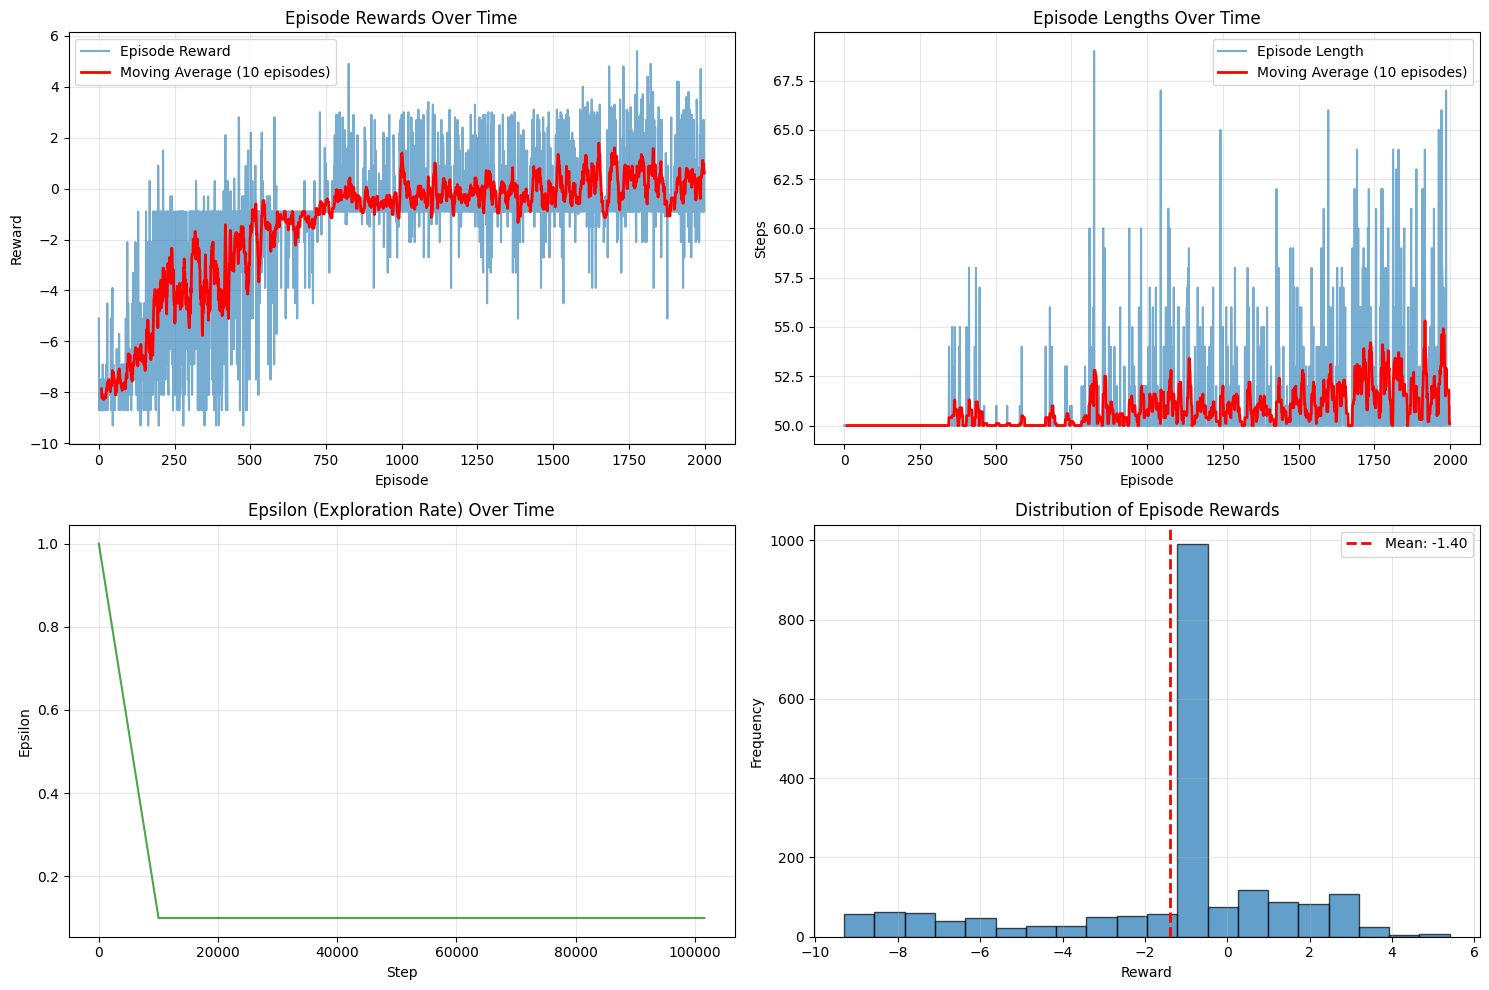


Training Summary
Total episodes: 2000
Average reward: -1.40 ± 2.89
Best episode reward: 5.40
Worst episode reward: -9.30
Average episode length: 50.8 ± 2.3
Final epsilon: 0.100
Total training steps: 100566


In [242]:
# Visualize learning trajectory
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Episode Rewards
axes[0, 0].plot(episode_rewards, alpha=0.6, label='Episode Reward')
# Moving average
if len(episode_rewards) >= 10:
    window = min(10, len(episode_rewards))
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(episode_rewards)), moving_avg, 
                    'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].set_title('Episode Rewards Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Episode Lengths
axes[0, 1].plot(episode_lengths, alpha=0.6, label='Episode Length')
if len(episode_lengths) >= 10:
    window = min(10, len(episode_lengths))
    moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(range(window-1, len(episode_lengths)), moving_avg, 
                    'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Lengths Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Epsilon Decay
axes[1, 0].plot(epsilon_values, 'g-', alpha=0.7)
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].set_title('Epsilon (Exploration Rate) Over Time')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Reward Distribution
axes[1, 1].hist(episode_rewards, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(episode_rewards), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(episode_rewards):.2f}')
axes[1, 1].set_xlabel('Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Episode Rewards')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("Training Summary")
print("="*50)
print(f"Total episodes: {len(episode_rewards)}")
print(f"Average reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"Best episode reward: {np.max(episode_rewards):.2f}")
print(f"Worst episode reward: {np.min(episode_rewards):.2f}")
print(f"Average episode length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
print(f"Final epsilon: {epsilon_values[-1]:.3f}")
print(f"Total training steps: {trainer.train_steps}")
print("="*50)


In [243]:
# Visualize the trained agent playing and save as GIF
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
try:
    import imageio
except ImportError:
    print("Installing imageio for GIF creation...")
    import subprocess
    subprocess.check_call(["pip", "install", "imageio"])
    import imageio

def visualize_agent_playing(q_net, env, frame_buffer, num_episodes=3, max_steps=500, epsilon=0.0, save_gif=True, gif_filename="flappy_bird_agent.gif"):
    """
    Visualize the trained agent playing Flappy Bird.
    
    Args:
        q_net: Trained Q-network
        env: Environment instance
        frame_buffer: FrameBuffer instance
        num_episodes: Number of episodes to visualize
        max_steps: Maximum steps per episode
        epsilon: Exploration rate (0.0 for pure exploitation)
    """
    q_net.eval()  # Set to evaluation mode
    all_episode_frames = []  # Store frames from all episodes for GIF
    
    for episode in range(num_episodes):
        # Reset environment
        observation, info = env.reset()
        frame_buffer.reset()
        
        # Get initial state
        state = process_observation(observation, frame_buffer, env)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        episode_reward = 0
        frames = []  # Store frames for visualization
        
        print(f"\nEpisode {episode + 1}/{num_episodes}")
        print("Playing...")
        
        for step in range(max_steps):
            # Select action (use epsilon for some exploration if desired)
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_net(state_tensor)
                    action = q_values.argmax(1).item()
            
            # Take step
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
            # Render and store frame
            rgb_frame = env.render()
            if rgb_frame is not None:
                frames.append(rgb_frame.copy())
            
            # Process next observation
            next_state = process_observation(next_observation, frame_buffer, env)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Update state
            state = next_state
            state_tensor = next_state_tensor
            
            if done:
                break
        
        print(f"Episode {episode + 1} completed!")
        print(f"  Steps: {step + 1}")
        print(f"  Total reward: {episode_reward:.2f}")
        
        # Store frames for GIF creation
        if frames:
            all_episode_frames.append(frames)
    
    # Create and save GIF
    if save_gif and all_episode_frames:
        print(f"\nCreating GIF from {sum(len(f) for f in all_episode_frames)} frames...")
        
        # Combine frames from all episodes (you can also save separate GIFs per episode)
        all_frames = []
        for episode_idx, episode_frames in enumerate(all_episode_frames):
            # Add episode separator frame (optional)
            if episode_idx > 0:
                separator = np.ones_like(episode_frames[0]) * 255
                all_frames.extend([separator] * 5)  # 5 blank frames between episodes
            
            # Add frames (can downsample to reduce file size)
            all_frames.extend(episode_frames[::2])  # Every 2nd frame to reduce size
        
        # Save as GIF
        print(f"Saving GIF with {len(all_frames)} frames to {gif_filename}...")
        imageio.mimsave(gif_filename, all_frames, fps=10, loop=0)
        print(f"✓ GIF saved as {gif_filename}!")
        
        # Also display a preview
        print("\nDisplaying preview (first 50 frames)...")
        fig, ax = plt.subplots(figsize=(10, 8))
        preview_frames = all_frames[:50:2]  # Show every 2nd frame of first 50
        for i, frame in enumerate(preview_frames):
            ax.clear()
            ax.imshow(frame)
            ax.set_title(f"Preview Frame {i*2}/{len(all_frames)}")
            ax.axis('off')
            display(fig)
            clear_output(wait=True)
            time.sleep(0.05)
        plt.close(fig)
    
    q_net.train()  # Set back to training mode
    print("\n✓ Visualization complete!")

# Run visualization with the trained model and save as GIF
# Note: If env was closed, create a new one
try:
    env.render()  # Test if env is still open
except:
    print("Creating new environment for visualization...")
    env = gym.make("FlappyBird-v0", render_mode='rgb_array')

print("="*60)
print("Visualizing Trained Agent and Saving GIF")
print("="*60)
visualize_agent_playing(
    q_net, 
    env, 
    frame_buffer, 
    num_episodes=3, 
    max_steps=1000,  # Longer episodes for better visualization
    epsilon=0.0,  # Pure exploitation
    save_gif=True,
    gif_filename="flappy_bird_agent.gif"
)



✓ Visualization complete!


In [244]:
# Alternative: Real-time visualization (simpler, shows one episode at a time)
def visualize_episode_realtime(q_net, env, frame_buffer, max_steps=500, epsilon=0.0):
    """
    Show one episode in real-time with live updates.
    """
    q_net.eval()
    
    # Reset environment
    observation, info = env.reset()
    frame_buffer.reset()
    
    # Get initial state
    state = process_observation(observation, frame_buffer, env)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    
    episode_reward = 0
    step_count = 0
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    print("Playing episode (press interrupt to stop)...")
    
    try:
        for step in range(max_steps):
            # Select action
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_net(state_tensor)
                    action = q_values.argmax(1).item()
            
            # Take step
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
            
            # Render and display
            rgb_frame = env.render()
            if rgb_frame is not None:
                ax.clear()
                ax.imshow(rgb_frame)
                ax.set_title(f"Step: {step_count} | Reward: {episode_reward:.2f} | Action: {'Flap' if action == 1 else 'No Flap'}")
                ax.axis('off')
                display(fig)
                clear_output(wait=True)
            
            # Process next observation
            next_state = process_observation(next_observation, frame_buffer, env)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Update state
            state = next_state
            state_tensor = next_state_tensor
            
            if done:
                print(f"\nEpisode ended after {step_count} steps")
                print(f"Total reward: {episode_reward:.2f}")
                break
                
    except KeyboardInterrupt:
        print(f"\nStopped after {step_count} steps")
        print(f"Total reward: {episode_reward:.2f}")
    
    plt.close(fig)
    q_net.train()
    
    return episode_reward, step_count

visualize_episode_realtime(q_net, env, frame_buffer, max_steps=500, epsilon=0.0)



Episode ended after 57 steps
Total reward: -0.80


(-0.8000000000000007, 57)